Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
!pip install --upgrade tensorflow

     |████████████████████████████████| 462 kB 4.2 MB/s 


In [3]:
!pip install --upgrade tensorflow-gpu

     |████████████████████████████████| 497.5 MB 29 kB/s 


In [4]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import PIL
from tensorflow import keras
from tensorflow.python.keras import layers
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from glob import glob

In [5]:
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
from pathlib import Path
import pathlib

In [8]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/My Drive/Train")
data_dir_test = pathlib.Path("/content/gdrive/My Drive/Test")

In [10]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


# Load using keras.preprocessing
Let's load these images off disk using the helpful image_dataset_from_directory utility.
# Create a dataset

Define some parameters for the loader:

In [11]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [12]:
# split the train data (80%) and validation (20%)
## define train ds
## use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size 180*180, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [13]:
## define validation ds
## use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size 180*180, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [14]:
## test ds
## Note, make sure your resize your images to the size 180*180, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [15]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Visualize the data


In [16]:
# Image Rescaling. The 1./255 is to convert from unit8 to float32 in range[0, 1]
image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_data_gen = image_generator.flow_from_directory(directory=data_dir_train,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    target_size=(img_height, img_width),
                                                    classes=list(class_names),
                                                    class_mode='categorical')

Found 2239 images belonging to 9 classes.


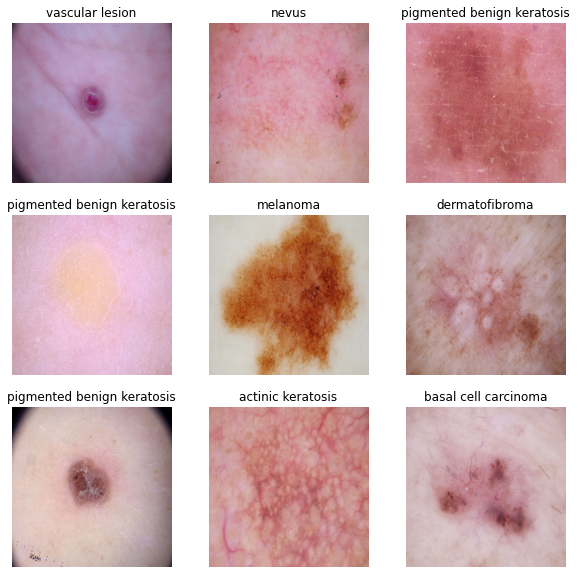

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.


In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the CNN Model

In [19]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))
]

In [20]:
input_shape = (img_height,img_width,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, 3, padding='same', activation=activ),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation=activ),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation=activ),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation=activ),
    layers.Dense(9, activation='softmax')
])



In [21]:
optimizer = 'adam'
loss_fn = "sparse_categorical_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [22]:
model.build

<bound method Sequential.build of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f422e1b0090>>

# Train the model

In [23]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [24]:
epochs = 20
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)



Epoch 1/20
56/56 [==============================] - 466s 2s/step - loss: 2.0186 - accuracy: 0.2746 - val_loss: 1.6900 - val_accuracy: 0.4094
Epoch 2/20
56/56 [==============================] - 4s 79ms/step - loss: 1.6556 - accuracy: 0.4118 - val_loss: 1.4668 - val_accuracy: 0.5101
Epoch 3/20
56/56 [==============================] - 4s 76ms/step - loss: 1.4467 - accuracy: 0.4888 - val_loss: 1.5829 - val_accuracy: 0.4116
Epoch 4/20
56/56 [==============================] - 4s 77ms/step - loss: 1.4024 - accuracy: 0.5073 - val_loss: 1.4570 - val_accuracy: 0.4899
Epoch 5/20
56/56 [==============================] - 4s 77ms/step - loss: 1.2581 - accuracy: 0.5580 - val_loss: 1.3731 - val_accuracy: 0.5235
Epoch 6/20
56/56 [==============================] - 4s 77ms/step - loss: 1.1842 - accuracy: 0.5887 - val_loss: 1.3853 - val_accuracy: 0.5436
Epoch 7/20
56/56 [==============================] - 4s 77ms/step - loss: 1.1016 - accuracy: 0.5949 - val_loss: 1.4220 - val_accuracy: 0.5235
Epoch 8/20
56

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 128)       0

# Visualizing training results

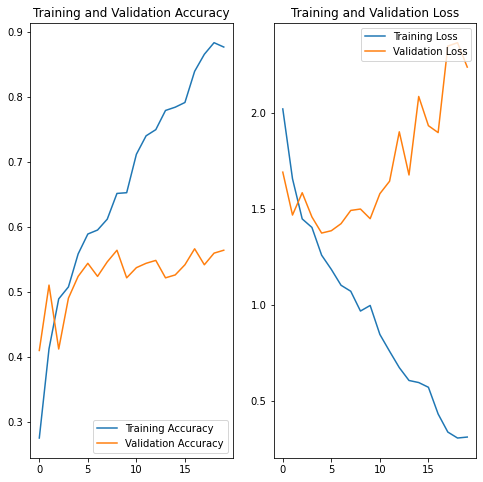

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Note: It is clearly evident from above that the model shows overfitting.

There are two observations to justify overfitting:


1.   After 20 epochs, we could see that validation losses are higher than training losses, and also validation accuracy drastically reduced compared to training accuracy

  

      *   Training loss: 0.3122 Vs Validation loss: 2.2363
      *  Training accuracy: 0.8767 Vs Validation accuracy: 0.5638


  


2.   The above Graph shows difference in the training and validation w.r.t accuracy and losses.



# Augmentation Strategy

In [27]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

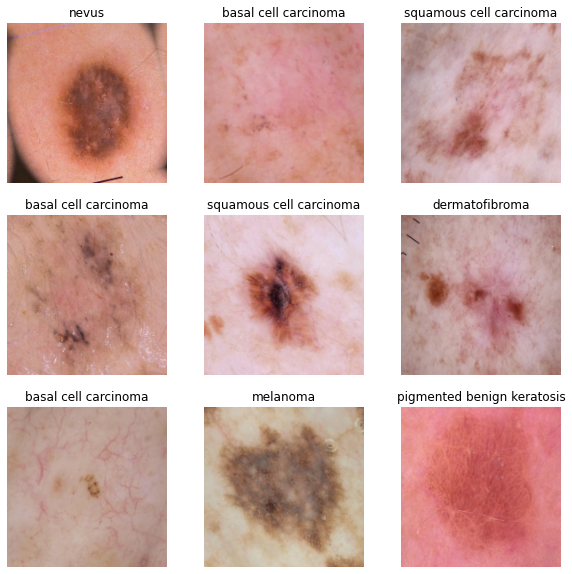

In [28]:
#visualize how your augmentation strategy works for one instance of training image.
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(images[i], 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

# Create the model, compile and train the model

In [29]:
## use Dropout layer if there is an evidence of overfitting in your findings
model = Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.15),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')
])

In [30]:
#Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
## train your model for 20 epochs
history =  model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 6s 88ms/step - loss: 2.0778 - accuracy: 0.2718 - val_loss: 1.7670 - val_accuracy: 0.3781
Epoch 2/20
56/56 [==============================] - 5s 83ms/step - loss: 1.6849 - accuracy: 0.3850 - val_loss: 1.6046 - val_accuracy: 0.4340
Epoch 3/20
56/56 [==============================] - 5s 83ms/step - loss: 1.5514 - accuracy: 0.4554 - val_loss: 1.4495 - val_accuracy: 0.5101
Epoch 4/20
56/56 [==============================] - 5s 82ms/step - loss: 1.4780 - accuracy: 0.4794 - val_loss: 1.4500 - val_accuracy: 0.5145
Epoch 5/20
56/56 [==============================] - 5s 82ms/step - loss: 1.3694 - accuracy: 0.5095 - val_loss: 1.3966 - val_accuracy: 0.5101
Epoch 6/20
56/56 [==============================] - 5s 83ms/step - loss: 1.3704 - accuracy: 0.5218 - val_loss: 1.4200 - val_accuracy: 0.5257
Epoch 7/20
56/56 [==============================] - 5s 82ms/step - loss: 1.3134 - accuracy: 0.5257 - val_loss: 1.3462 - val_accuracy: 0.5168
Epoch 8/20
56/56 [======

##Visualising the results


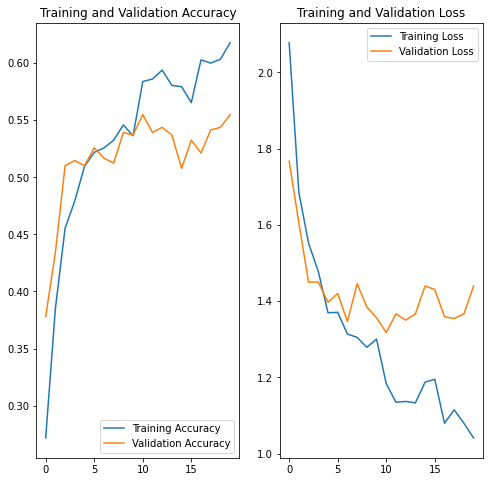

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As per the above model 2 result, the current model is not overfit, and it performs better than previous model after adding Augumentation strategy and dropout method.

Please find the training and validation accuracy:

*   The training accuracy: 0.6177 & validation accuracy: 0.5548
*   The training loss: 1.0407 & validation loss: 1.4396




#Find the distribution of classes in the training dataset.

**Context**: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [33]:
total_image_count = len(list(data_dir_train.glob('**/*/*.jpg')))
perc_class = {}
for name in class_names:
    perc_class[name] = round((len(list(data_dir_train.glob('{0}/*.jpg'.format(name)))) / total_image_count)*100,2)
df = pd.DataFrame(list(perc_class.items()), columns=['Class', 'Distribution Percentage'])

df

,Class,Distribution Percentage
0,actinic keratosis,5.09
1,basal cell carcinoma,16.79
2,dermatofibroma,4.24
3,melanoma,19.56
4,nevus,15.94
5,pigmented benign keratosis,20.63
6,seborrheic keratosis,3.44
7,squamous cell carcinoma,8.08
8,vascular lesion,6.21


In [34]:
# Get the distribution of data for each class
total_count = 0
data_dict = {}
for name in class_names:
    data_dict[name] = len(list(data_dir_train.glob('{0}/*.jpg'.format(name))))
    total_count += len(list(data_dir_train.glob('{0}/*.jpg'.format(name))))

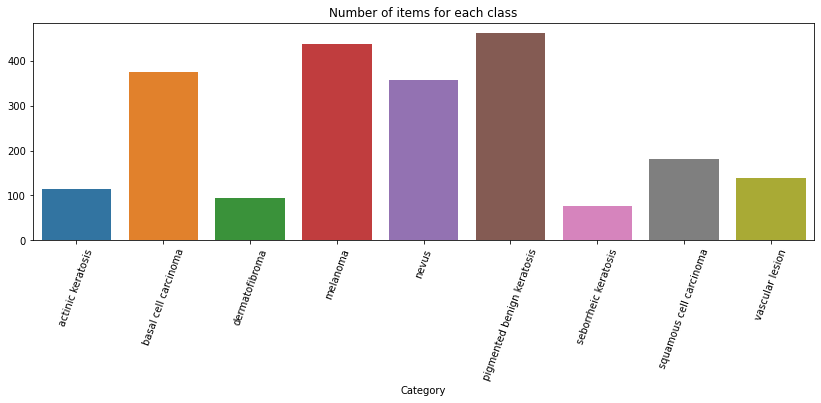

In [35]:
# Plot the distribution of data using bar plot
f, ax = plt.subplots(1,1, figsize=(14,4))
g = sns.barplot(x=list(data_dict.keys()), y = list(data_dict.values()))
g.set_title("Number of items for each class")
g.set_xlabel("Category")
plt.xticks(rotation=70)
plt.show()

#Write your findings here:
- Which class has the least number of samples?
  **seborrheic keratosis** has least number of samples -  
- Which classes dominate the data in terms proportionate number of samples?
  **pigmented benign keratosis** has  the highest number of samples

# Rectify the class imbalance

In [36]:
!pip install Augmentor

In [37]:
path_to_training_dataset="/content/gdrive/MyDrive/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F422E7F4250>: 100%|██████████| 500/500 [00:23<00:00, 21.00 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F422E9E3C10>: 100%|██████████| 500/500 [00:25<00:00, 19.56 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F422E7FDC10>: 100%|██████████| 500/500 [00:26<00:00, 18.69 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F422E7D3F50>: 100%|██████████| 500/500 [01:59<00:00,  4.18 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1504x1129 at 0x7F42AA8FF350>: 100%|██████████| 500/500 [01:40<00:00,  4.95 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F422E79E510>: 100%|██████████| 500/500 [00:21<00:00, 23.80 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F422E868890>: 100%|██████████| 500/500 [00:50<00:00,  9.84 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F422E843710>: 100%|██████████| 500/500 [00:22<00:00, 22.72 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F422EC15F90>: 100%|██████████| 500/500 [00:21<00:00, 23.05 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [38]:
# Get the total number of samples newly added using Augumentor
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


#Lets see the distribution of augmented data after adding new images to the original training data.

In [39]:
# Get the list of paths that originally had without Augumentor
org_path_list = [x for x in glob(os.path.join(data_dir_train, '*','*.jpg'))]
org_path_list

['/content/gdrive/My Drive/Train/pigmented benign keratosis/ISIC_0024435.jpg',
 '/content/gdrive/My Drive/Train/pigmented benign keratosis/ISIC_0024495.jpg',
 '/content/gdrive/My Drive/Train/pigmented benign keratosis/ISIC_0024711.jpg',
 '/content/gdrive/My Drive/Train/pigmented benign keratosis/ISIC_0025030.jpg',
 '/content/gdrive/My Drive/Train/pigmented benign keratosis/ISIC_0024643.jpg',
 '/content/gdrive/My Drive/Train/pigmented benign keratosis/ISIC_0024477.jpg',
 '/content/gdrive/My Drive/Train/pigmented benign keratosis/ISIC_0024761.jpg',
 '/content/gdrive/My Drive/Train/pigmented benign keratosis/ISIC_0025016.jpg',
 '/content/gdrive/My Drive/Train/pigmented benign keratosis/ISIC_0024748.jpg',
 '/content/gdrive/My Drive/Train/pigmented benign keratosis/ISIC_0024871.jpg',
 '/content/gdrive/My Drive/Train/pigmented benign keratosis/ISIC_0024890.jpg',
 '/content/gdrive/My Drive/Train/pigmented benign keratosis/ISIC_0024782.jpg',
 '/content/gdrive/My Drive/Train/pigmented benign ke

In [40]:
# Get the class names for each paths of original data
lesion_list_org = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
print(len(lesion_list_org))

2239


In [41]:
# Add both Path list and class names of original data
dataframe_dict_org = dict(zip(org_path_list, lesion_list_org))

In [42]:
# Create a dataframe using original data
df1 = pd.DataFrame(list(dataframe_dict_org.items()),columns = ['Path','Label'])
len(df1)

2239

In [43]:
# Get the list of paths that new added using Augumentor
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/My Drive/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024676.jpg_44819dd5-42b7-4215-9038-433c87b343dd.jpg',
 '/content/gdrive/My Drive/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028294.jpg_81babf96-1f9b-459b-9e80-7bcf535ca18a.jpg',
 '/content/gdrive/My Drive/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025661.jpg_2495ffa7-d064-4bcb-a8d2-fcbdf7c38853.jpg',
 '/content/gdrive/My Drive/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0024877.jpg_46db9c9f-a67b-4fde-b784-14ed39b5119f.jpg',
 '/content/gdrive/My Drive/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025986.jpg_a971772c-0d30-480a-a345-bc40779cfe98.jpg',
 '/content/gdrive/My Drive/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026967.jpg_f0f473c2-895a-4fda-a488-44fd565e95bf.jpg',
 '/content/gdrive/My D

In [44]:
# Get the class names for each paths of newly added data
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [45]:
# Add both Path list and class names of newly added data
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [46]:
# Create a dataframe using newly added data using Augumentor
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# Merge orginal data with newly added data
new_df = df1.append(df2)

In [47]:
# Show the dsitribution of data after merging
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#Train the model on the data created using Augmentor

In [48]:
batch_size = 32
img_height = 180
img_width = 180


#Create a Training Data Set

In [49]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset =  'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#Create a Validation Data Set


In [50]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#Create your model (make sure to include normalization)

In [55]:
model = Sequential([

    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    layers.MaxPooling2D(),

    #layers.Conv2D(128, 3, padding='same', activation='relu'),
    #tf.keras.layers.BatchNormalization(),
    #layers.MaxPooling2D(),

    layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),

    layers.Dense(9, activation='softmax')
])

#Compile the model

In [56]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#Train the Model

In [57]:
epochs = 30
## use 30 epochs.
history =  model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 45s 248ms/step - loss: 1.6418 - accuracy: 0.4436 - val_loss: 4.1015 - val_accuracy: 0.1084
Epoch 2/30
169/169 [==============================] - 42s 243ms/step - loss: 1.2711 - accuracy: 0.5349 - val_loss: 2.6475 - val_accuracy: 0.2004
Epoch 3/30
169/169 [==============================] - 42s 243ms/step - loss: 1.1371 - accuracy: 0.5814 - val_loss: 1.6549 - val_accuracy: 0.4328
Epoch 4/30
169/169 [==============================] - 42s 239ms/step - loss: 1.0520 - accuracy: 0.6052 - val_loss: 1.0729 - val_accuracy: 0.5850
Epoch 5/30
169/169 [==============================] - 41s 238ms/step - loss: 0.9639 - accuracy: 0.6417 - val_loss: 2.5708 - val_accuracy: 0.2799
Epoch 6/30
169/169 [==============================] - 41s 236ms/step - loss: 0.9039 - accuracy: 0.6669 - val_loss: 5.7854 - val_accuracy: 0.2331
Epoch 7/30
169/169 [==============================] - 42s 239ms/step - loss: 0.8072 - accuracy: 0.7001 - val_loss: 1.0884 - val_accuracy: 0.6

#Visualise the Model results


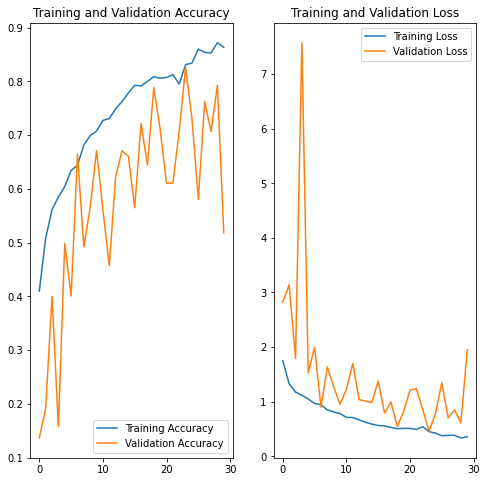

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Summary:
1. The above model shows that model is not overfit. This is because, we were able to resolve the class rebalance issue by adding more samples of images using Augumentor.
2. The model is able to predict well by using multiple layers of Convolution 2D (Upto 256).
3. Further, the model is able to generalize well by using Batch Normalization in multiple layers.
4. In addition to the above, dropout (0.5) has been added to generalize the model.
5. The training accuracy has improved with a value of 0.8863 whereas validation accuracy is now 0.8374.
6. The training loss is reduced to 0.2916 and validation loss is reduced to 0.5235
7. The model can be further improved by adding more images.




```
# This is formatted as code
```

